In [1]:
import torch
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import plotting
from sklearn.metrics import auc
from neurovlm.metrics import recall_curve

from neurovlm.data import data_dir
from neurovlm.retrieval_resources import (
    _load_autoencoder, _load_masker, _proj_head_mse_adhoc,
    _proj_head_image_infonce, _proj_head_text_infonce,
)

In [2]:
# Load pre-trained models
autoencoder = _load_autoencoder()
masker = _load_masker()
proj_head = _proj_head_mse_adhoc()
proj_head_text = _proj_head_text_infonce()
proj_head_image = _proj_head_image_infonce()

# Load neurovault
neurovault_data = torch.load(
    data_dir / "neurovault_filtered.pt", weights_only=False
)
df_neuro, df_pubs, _, neuro_clust, _, _, text_emb = neurovault_data.values()

In [5]:
sim_mean = torch.zeros(len(df_pubs))
sim_mean_dec = torch.zeros(len(df_pubs))

latent_image = torch.zeros((len(df_pubs), 384))
latent_text = torch.zeros((len(df_pubs), 384))

latent_image_dec = torch.zeros((len(df_pubs), 384))
latent_text_dec = torch.zeros((len(df_pubs), 384))

for i, doi in enumerate(df_pubs["doi"]):
    with torch.no_grad():

        # Encoded image
        im = autoencoder.encoder((neuro_clust[np.where(df_neuro["doi"] == doi)[0]] > 0).to(torch.float32))

        # Decoder model
        tx = text_emb[i] / text_emb[i].norm()
        tx_proj = proj_head(tx)
        tx_proj = tx_proj / tx_proj.norm()
        latent_text_dec[i] = tx_proj

        sim = (im / im.norm(dim=1)[:, None]) @ tx_proj
        amax = np.argmax(sim)
        sim_mean_dec[i] = sim[amax]
        latent_image_dec[i] = im[amax]

        # Contrastive model
        tx_proj = proj_head_text(tx)
        tx_proj = tx_proj / tx_proj.norm()
        latent_text[i] = tx_proj

        # im = proj_head_image(im / im.norm(dim=1)[:, None])
        im = proj_head_image(im)
        sim = (im / im.norm(dim=1)[:, None]) @ tx_proj
        amax = np.argmax(sim)
        sim_mean[i] = sim[amax]
        latent_image[i] = im[amax]

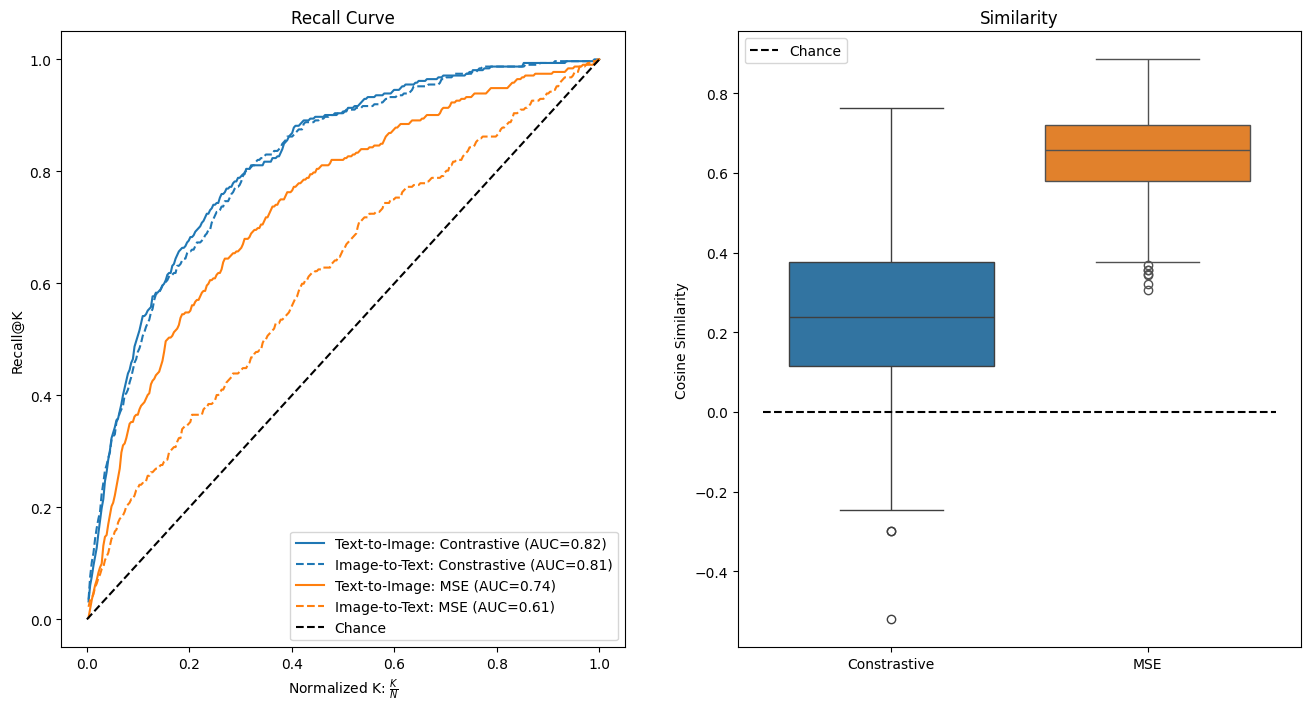

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

t_to_i, i_to_t = recall_curve(latent_text, latent_image)
x = np.arange(1, len(t_to_i)+1) / len(t_to_i)
axes[0].plot(x, t_to_i, label=f"Text-to-Image: Contrastive (AUC={round(auc(x, t_to_i), 2)})", color="C0")
axes[0].plot(x, i_to_t, label=f"Image-to-Text: Constrastive (AUC={round(auc(x, i_to_t), 2)})", color="C0", ls='--')

t_to_i, i_to_t = recall_curve(latent_text_dec, latent_image_dec)
x = np.arange(1, len(t_to_i)+1) / len(t_to_i)
axes[0].plot(x, t_to_i, label=f"Text-to-Image: MSE (AUC={round(auc(x, t_to_i), 2)})", color="C1")
axes[0].plot(x, i_to_t, label=f"Image-to-Text: MSE (AUC={round(auc(x, i_to_t), 2)})", color="C1", ls='--')

axes[0].set_ylabel("Recall@K")
axes[0].set_xlabel(r"Normalized K: $\frac{K}{N}$")
axes[0].set_title("Recall Curve")
axes[0].plot([0, 1], [0, 1], color='k', ls='--', label="Chance")
axes[0].legend()

sns.boxplot(x=[0]*len(sim_mean), y=sim_mean, ax=axes[1])
sns.boxplot(x=[1]*len(sim_mean_dec), y=sim_mean_dec, ax=axes[1], color="C1")
axes[1].plot([-.5, 1.5], [0, 0], color='k', ls='--', label="Chance")

axes[1].set_xticks([0, 1], ["Constrastive", "MSE"])
axes[1].set_ylabel("Cosine Similarity")
axes[1].set_title("Similarity")
axes[1].legend();